In [1]:
import torch 
from smartem.offline.train_mb_error_detector.NNtools import UNet as UNet_offline
from smartem.online.models.UNet import UNet as UNet_online
import matplotlib.pyplot as plt
import numpy as np

In [2]:
weights_path = "/home/tommy-local/projects/smartem/SmartEM/pretrained_models/em2mb_best_core.pth"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

em2mb_net = UNet_online(1, 2)
em2mb_net.load_state_dict(torch.load(weights_path))
em2mb_net.eval()
em2mb_net.to(device)

UNet(
  (inc): DoubleConv(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
  )
  (down1): Down(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dc): DoubleConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

# Modify image of same size to have the same center as the reference

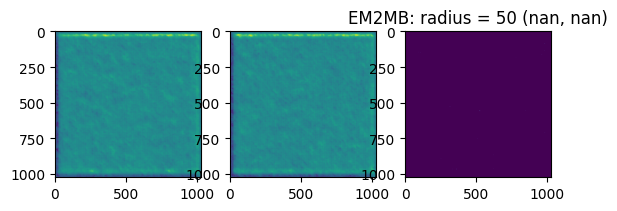

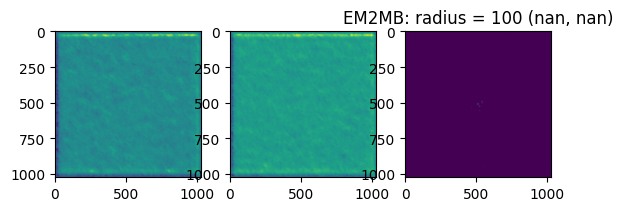

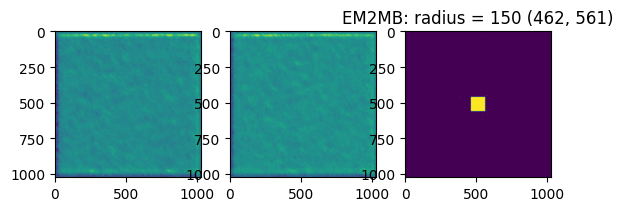

In [3]:
im_ref = torch.randn((1, 1, 1024, 1024), device=device, dtype=torch.float32)
out_ref = em2mb_net(im_ref).cpu().detach().numpy()
out_ref = np.squeeze(out_ref[0,0,:,:])

for r in range(50, 200, 50):
    im_rand = torch.randn((1, 1, 1024, 1024), device=device, dtype=torch.float32)
    im_rand[:,:,512-r:512+r,512-r:512+r] = im_ref[:,:,512-r:512+r,512-r:512+r]
    out_rand = em2mb_net(im_rand).cpu().detach().numpy()
    out_rand = np.squeeze(out_rand[0,0,:,:])

    if r > 100:
        sum = np.sum(out_ref == out_rand, axis=0)
        equal_idxs = np.where(sum > 20)[0]
    else:
        equal_idxs = [np.nan, np.nan]

    f, axs = plt.subplots(ncols=3)
    axs[0].imshow(out_ref)
    axs[1].imshow(out_rand)
    axs[2].imshow(out_ref == out_rand)
    plt.title(f"EM2MB: radius = {r} {(equal_idxs[0], equal_idxs[-1])}")
    plt.show()




# Crop the center of the reference

torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 1024, 1024])


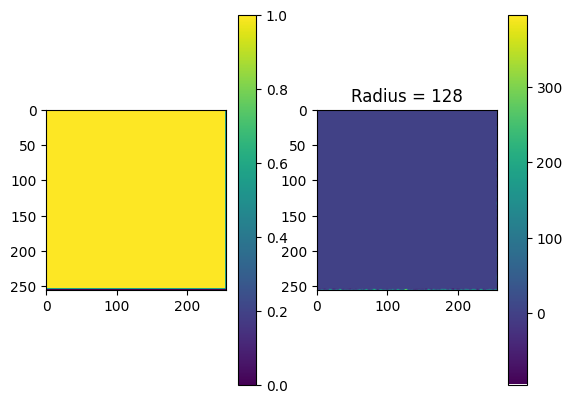

torch.Size([1, 128, 128, 128])
torch.Size([1, 128, 512, 512])


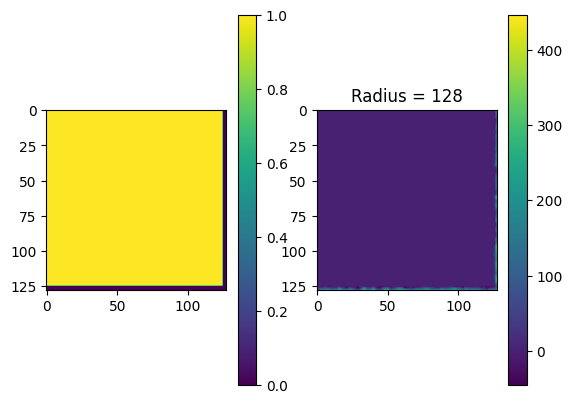

torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 256, 256])


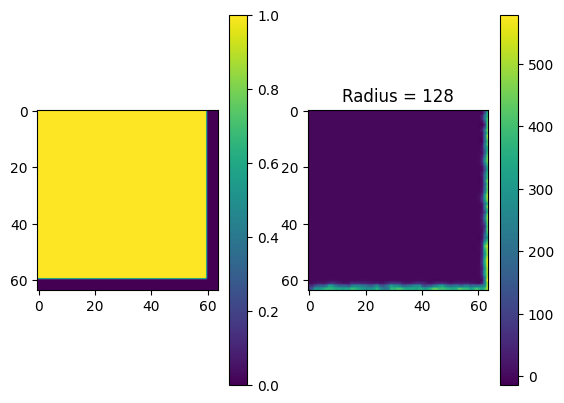

torch.Size([1, 512, 32, 32])
torch.Size([1, 512, 128, 128])


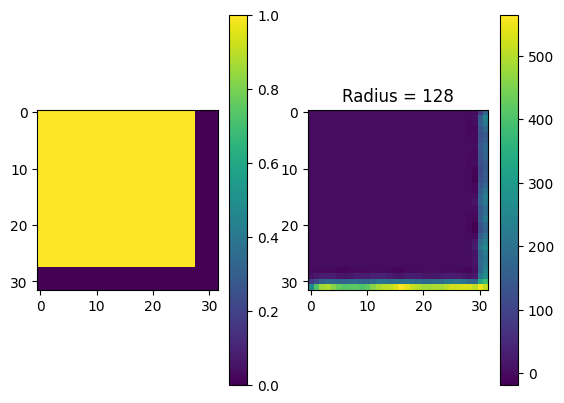

torch.Size([1, 1024, 16, 16])
torch.Size([1, 1024, 64, 64])


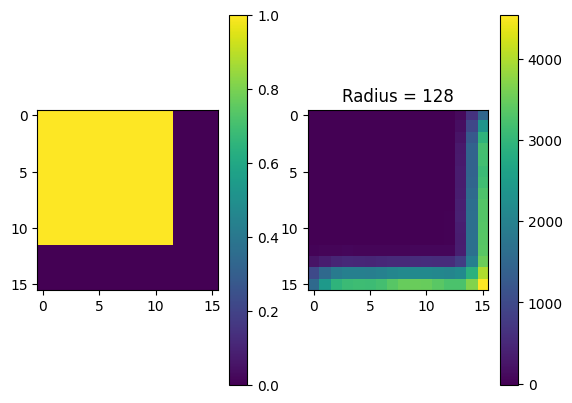

TypeError: Up.forward() missing 1 required positional argument: 'x2'

In [24]:
im_ref = torch.randn((1, 1, 1024, 1024), device=device, dtype=torch.float32)
out_ref = em2mb_net(im_ref).cpu().detach().numpy()
out_ref = np.squeeze(out_ref[0,0,:,:])

for r in range(128, 513, 128):
    im_crop = im_ref[:,:,:2*r,:2*r]

    cur_act_ref = em2mb_net.inc(im_ref)
    cur_act_crop = em2mb_net.inc(im_crop)
    ds_factors = [i for i in range(5)] + [i for i in range(3,0,-1)]
    for i, layer in zip(ds_factors, [em2mb_net.down1, em2mb_net.down2, em2mb_net.down3, em2mb_net.down4, em2mb_net.up1]):
        print(cur_act_crop.shape)
        print(cur_act_ref.shape)
        plot_ref = np.squeeze(cur_act_ref.cpu().detach().numpy())[:,:2*r//2**i,:2*r//2**i]
        plot_crop = np.squeeze(cur_act_crop.cpu().detach().numpy())
        plot_ref = np.sum(plot_ref, axis=0)
        plot_crop = np.sum(plot_crop, axis=0)
        f, ax = plt.subplots(ncols=2)
        eq_plot = ax[0].imshow(plot_ref == plot_crop)
        f.colorbar(eq_plot, ax=ax[0])
        im_plot = ax[1].imshow(plot_ref - plot_crop)
        f.colorbar(im_plot, ax=ax[1])
        plt.title(f"Radius = {r}")
        plt.show()


        cur_act_ref = layer(cur_act_ref)
        cur_act_crop = layer(cur_act_crop)
    break


    out_rand = em2mb_net(im_crop).cpu().detach().numpy()
    out_rand = np.squeeze(out_rand[0,0,:,:])

    out_ref_crop = out_ref[:2*r,:2*r]
    if out_ref.shape == out_ref_crop.shape:
        print(np.all(out_ref == out_ref_crop))


    f, ax = plt.subplots(ncols=2)
    eq_plot = ax[0].imshow(out_ref_crop == out_rand)
    f.colorbar(eq_plot, ax=ax[0])
    im_plot = ax[1].imshow(out_ref_crop - out_rand)
    f.colorbar(im_plot, ax=ax[1])
    # ax[0].imshow(out_ref[512-r:512+r,512-r:512+r] == out_rand)
    # im_plot = ax[1].imshow(out_ref[512-r:512+r,512-r:512+r] - out_rand)
    # f.colorbar(im_plot, ax=ax[1])
    plt.title(f"Radius = {r}")
    plt.show()


